In [1]:
pip install pytube  torchvision opencv-python matplotlib pytubefix

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 7.4 MB/s eta 0:00:00


In [2]:
from pytubefix import YouTube
from pytubefix.cli import on_progress

# Download video using pytube
video_url = 'https://www.youtube.com/watch?v=l3NJNFmg09k'
yt = YouTube(video_url, on_progress_callback=on_progress)
yt.streams.filter(progressive=True, file_extension='mp4').first().download(output_path='/content')


'/content/Football match.mp4'

## **Task 1: Object Detection using Faster-RCNN**

In this task, we implement object detection on a video using the **Faster-RCNN** model with a **ResNet-50 FPN (Feature Pyramid Network)** backbone. The objective is to detect the "person" and "sports ball" classes from the COCO dataset using a pre-trained Faster-RCNN model. Below, I’ll provide an explanation of each step involved, along with a discussion on the architecture and key components.

### **Faster-RCNN Overview**

Faster-RCNN is a two-stage object detection model:

1. **Region Proposal Network (RPN):** Proposes candidate bounding boxes where objects might be located.
2. **Fast-RCNN:** Classifies the objects in the proposed regions and refines their bounding boxes.

The model's backbone (ResNet-50 FPN) is used to extract feature maps from the input image, which are then passed through the RPN to generate object proposals. These proposals are subsequently processed by the Fast-RCNN head to classify the objects and perform bounding box regression.

In [22]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
import cv2
import numpy as np

# Load Faster-RCNN pre-trained model
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# COCO classes
# Note: 0 is background in COCO, so we use 'person' at index 1 and 'sports ball' at index 37
classes = ['__background__', 'person', 'sports ball']

# Function to process video and apply Faster-RCNN
def process_video(input_video_path, output_video_path):
    cap = cv2.VideoCapture(input_video_path)
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))

    # Create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_video_path, fourcc, 30.0, (frame_width, frame_height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert frame to tensor and send to device
        frame_tensor = F.to_tensor(frame).unsqueeze(0).to(device)

        # Get predictions
        with torch.no_grad():
            prediction = model(frame_tensor)

        # Loop through predictions
        for element in range(len(prediction[0]['labels'])):
            label = prediction[0]['labels'][element].item()
            score = prediction[0]['scores'][element].cpu().numpy()


            # Set different thresholds for person (ID 1) and sports ball (ID 37)
            if label == 1:  # Person
                threshold = 0.5
            elif label == 37:  # Sports Ball
                threshold = 0.3  # Lower threshold for ball

            # Check if score is above the respective threshold
            if score > threshold:
                box = prediction[0]['boxes'][element].cpu().numpy()

                # Map label to the classes list
                if label == 1:  # Person
                    label_name = classes[1]
                elif label == 37:  # Sports ball
                    label_name = classes[2]

                # Draw bounding box and label
                cv2.rectangle(frame, (int(box[0]), int(box[1])),
                              (int(box[2]), int(box[3])), (0, 255, 0), 2)
                cv2.putText(frame, f'{label_name}: {score:.2f}',
                            (int(box[0]), int(box[1]-10)), cv2.FONT_HERSHEY_SIMPLEX,
                            0.9, (0, 255, 0), 2)

        # Write frame to output video
        out.write(frame)

    cap.release()
    out.release()

# Example usage
input_video = '/content/Football match.mp4'
output_video = '/content/Football_match_part1.mp4'
process_video(input_video, output_video)


### **Explanation of Backbone (ResNet-50 FPN)**

### **ResNet-50 Backbone**

- **ResNet-50** is a deep residual network with 50 layers. It helps to avoid the vanishing gradient problem by using residual connections that allow the model to learn deeper features.
- In Faster-RCNN, ResNet-50 serves as the **feature extractor**, converting the input image into feature maps that can be used for generating region proposals (RPN) and detecting objects (Fast-RCNN head).

### **Feature Pyramid Network (FPN)**

- **FPN** is a structure built on top of the ResNet backbone to generate **multi-scale feature maps**. This helps the model to detect objects of varying sizes (e.g., small objects like the ball or large objects like a person).
- The FPN enables Faster-RCNN to produce high-quality detections at different resolutions, improving detection accuracy for both small and large objects.

---

### **Key Points to Remember**

- **Faster-RCNN** uses a **two-stage object detection** approach: Region Proposal Network (RPN) and Fast-RCNN for classification and bounding box regression.
- The **backbone** of the model, **ResNet-50**, is used for feature extraction, and **FPN** enhances its capability to detect objects at multiple scales.
- **Confidence thresholds** are applied to filter out low-confidence predictions (e.g., only boxes with scores higher than 0.5 are drawn).

In [5]:
!pip install deep_sort_realtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 18.3 MB/s eta 0:00:00



##**Task 2**: **Deep-SORT for Multi-Object Tracking**

---

#### **1. Understanding Deep-SORT**

Deep-SORT (Deep Learning-based SORT) is an advanced multi-object tracking algorithm that combines the **SORT (Simple Online and Realtime Tracking)** algorithm with a deep learning-based appearance feature extractor.

**Key Concepts:**
- **SORT**: A tracking algorithm that uses a Kalman filter for predicting the future locations of objects and the Hungarian algorithm for matching detected objects to existing tracks.
- **Deep-SORT**: Enhances SORT by using a **deep neural network** to extract appearance features for objects, allowing for more robust tracking even under occlusion or appearance changes.

##### **Kalman Filter in Deep-SORT**:
The Kalman filter is used to predict the position of each tracked object and update its state after each detection. It helps to smooth out the tracking and handle noisy detections.

##### **Hungarian Algorithm**:
The Hungarian algorithm is used to assign detected objects to existing tracks. It finds the optimal match based on a cost matrix that includes both the Kalman filter prediction and the appearance features.

---



#### **2. Deep-SORT Architecture**

**Deep-SORT** can be broken down into the following components:

1. **Object Detection**:
   - Use an object detector (like **Faster-RCNN**) to detect persons and the ball in each frame of the video.

2. **Kalman Filter**:
   - For each tracked object (soccer players and ball), we maintain a Kalman filter that predicts the object's next location and updates its state.

3. **Appearance Feature Extraction**:
   - A **deep neural network** (usually a CNN) extracts appearance features from the detected object to help distinguish between objects with similar motion patterns.

4. **Hungarian Algorithm**:
   - After object detection and feature extraction, the **Hungarian algorithm** is used to match objects from the current frame with those tracked in previous frames based on a combination of motion and appearance similarity.

5. **Tracking Update**:
   - The algorithm updates the tracks with new detections and handles cases where objects are lost or reappear in the scene.

---

#### **3. Architecture Diagram**



**Diagram Components:**
- **Input Video Frames**
  - Input frames containing multiple objects (players and the ball) detected in each frame.
  
- **Faster-RCNN** (Object Detection):
  - Extracts bounding boxes and class labels (person, ball) from each frame.

- **Kalman Filter**:
  - Predicts the future state of the object (position and velocity).

- **Deep Feature Extraction** (Appearance Feature Extractor):
  - A neural network extracts appearance features to distinguish between different objects.

- **Hungarian Algorithm** (Matching):
  - Assigns detections to the existing tracks by minimizing a cost function.

- **Tracking Update**:
  - Updates the track information based on the matched detections.


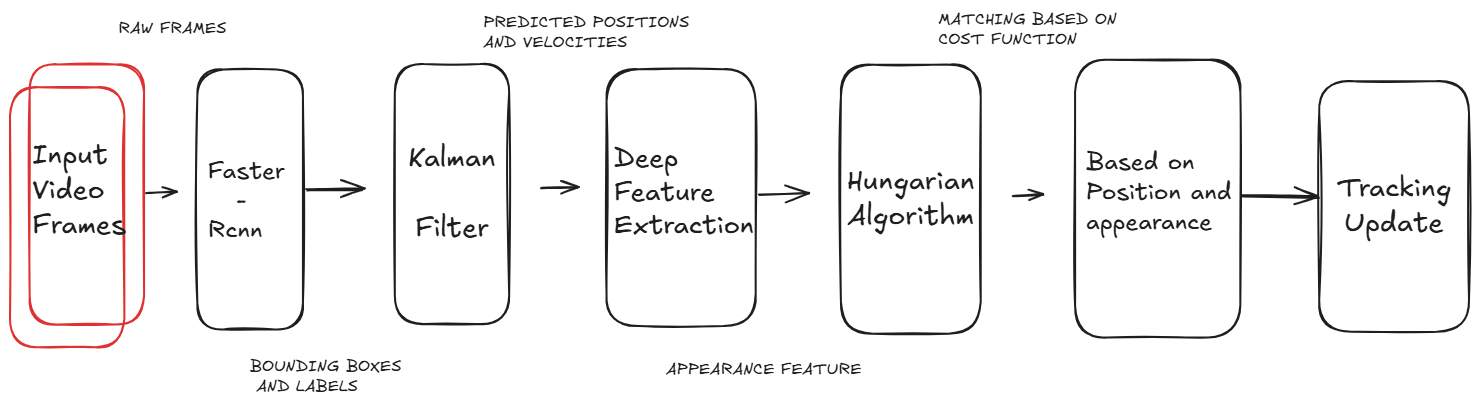





#### **4. Kalman Filter Equations**

In the context of tracking, the **Kalman Filter** helps predict the object's state (position and velocity) and update it as new observations (detections) come in. Here are the key equations:

- **State Prediction:**

$$
 \hat{x}_k = A \cdot \hat{x}_{k-1} + B \cdot u_k
$$

Where:
- \( $ \hat{x}_k \ $) is the predicted state of the object at time \( k \).
- \( A \) is the state transition matrix.
- \( B \) is the control matrix (if control input is involved).
- \( u_k \) is the control vector (if any).

- **Covariance Prediction:**

$$
P_k = A \cdot P_{k-1} \cdot A^T + Q
$$

Where:
- \( P_k \) is the predicted covariance matrix of the state.
- \( Q \) is the process noise covariance matrix.

- **Kalman Gain:**

$$
K_k = P_k \cdot H^T \cdot \left( H \cdot P_k \cdot H^T + R \right)^{-1}
$$

Where:
- \( K_k \) is the Kalman Gain.
- \( H \) is the measurement matrix.
- \( R \) is the measurement noise covariance matrix.

- **State Update:**

$$
\hat{x}_k = \hat{x}_k + K_k \cdot \left( z_k - H \cdot \hat{x}_k \right)
$$

Where:
- \( z_k \) is the actual measurement of the object (from detection).

- **Covariance Update:**

$$
P_k = \left( I - K_k \cdot H \right) \cdot P_k
$$

Where:
- \( I \) is the identity matrix.

These equations describe the prediction and update steps of the Kalman filter in tracking.

---

#### **5. Hungarian Algorithm Explanation**

The **Hungarian Algorithm** is used to assign detections (from the current frame) to existing tracks based on a cost matrix. The cost matrix usually includes:
1. **Motion Cost** (based on Kalman filter prediction): How much the detected object’s predicted position differs from the actual position.
2. **Appearance Cost** (based on feature matching): How much the appearance of the detected object (e.g., the player or ball) matches the object being tracked.

The Hungarian algorithm works as follows:
1. Create a cost matrix where each row represents a track, and each column represents a detection.
2. Compute the cost (or distance) between each track and each detection based on the predicted state and appearance features.
3. The Hungarian algorithm minimizes the total cost (i.e., finding the optimal assignment) between tracks and detections.

This process ensures that detections are accurately assigned to the correct track.





#### **6. Implementation of Deep-SORT**

You can use the pre-trained **Faster-RCNN** model from Task 1 to detect objects in each frame of the video. Then, for each detection, you’ll run the **Deep-SORT** algorithm to track both the players and the ball.

- **Deep-SORT Flow**:
  1. **Detect objects** (persons and balls) using Faster-RCNN.
  2. **Extract features** for each detection using a feature extractor (CNN).
  3. **Update the Kalman filter** for each tracked object.
  4. **Match detections to existing tracks** using the Hungarian algorithm.
  5. **Update tracks** with the new positions and states.



In [ ]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
import cv2
import numpy as np
from scipy.optimize import linear_sum_assignment
from sklearn.metrics.pairwise import cosine_similarity

# Initialize Faster-RCNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# COCO classes
classes = ['__background__', 'person', 'sports ball']

# Kalman Filter Class (Defined Above)
class KalmanFilter:
    def __init__(self):
        self.dt = 1
        self.A = np.array([[1, 0, self.dt, 0], [0, 1, 0, self.dt], [0, 0, 1, 0], [0, 0, 0, 1]])
        self.H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
        self.P = np.eye(4)
        self.R = np.eye(2) * 1
        self.Q = np.eye(4) * 0.1

    def predict(self, state, covariance):
        state = np.dot(self.A, state)
        covariance = np.dot(np.dot(self.A, covariance), self.A.T) + self.Q
        return state, covariance

    def update(self, state, covariance, measurement):
        y = measurement - np.dot(self.H, state)
        S = np.dot(self.H, np.dot(covariance, self.H.T)) + self.R
        K = np.dot(np.dot(covariance, self.H.T), np.linalg.inv(S))
        state = state + np.dot(K, y)
        covariance = covariance - np.dot(K, np.dot(self.H, covariance))
        return state, covariance

# Tracker Class (Defined Above)
class Tracker:
    def __init__(self):
        self.kf = KalmanFilter()
        self.tracks = {}
        self.track_id = 0
        self.max_age = 5

    def update_tracks(self, detections):
        new_tracks = {}
        unmatched_tracks = list(self.tracks.keys())
        unmatched_detections = list(range(len(detections)))

        if self.tracks:
            track_positions = np.array([track['state'][:2] for track in self.tracks.values()])
            detection_positions = np.array([d[:2] for d in detections])
            cost_matrix = np.linalg.norm(track_positions[:, None, :] - detection_positions[None, :, :], axis=2)
            row_ind, col_ind = linear_sum_assignment(cost_matrix)

            for r, c in zip(row_ind, col_ind):
                if cost_matrix[r, c] < 50:  # Distance threshold
                    unmatched_tracks.remove(list(self.tracks.keys())[r])
                    unmatched_detections.remove(c)
                    track_id = list(self.tracks.keys())[r]
                    state, covariance = self.kf.predict(
                        self.tracks[track_id]['state'], self.tracks[track_id]['covariance']
                    )
                    state, covariance = self.kf.update(state, covariance, detections[c])
                    new_tracks[track_id] = {'state': state, 'covariance': covariance, 'age': 0}

        for i in unmatched_detections:
            self.track_id += 1
            new_tracks[self.track_id] = {
                'state': np.array([*detections[i], 0, 0]),
                'covariance': np.eye(4),
                'age': 0
            }

        for track_id in unmatched_tracks:
            self.tracks[track_id]['age'] += 1
            if self.tracks[track_id]['age'] <= self.max_age:
                new_tracks[track_id] = self.tracks[track_id]

        self.tracks = new_tracks

    def draw_tracks(self, frame):
        for track_id, track in self.tracks.items():
            x, y = track['state'][:2].astype(int)
            cv2.putText(frame, f'ID {track_id}', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
            cv2.circle(frame, (x, y), 5, (0, 0, 255), -1)
# Video Processing Function
def process_video_with_tracking(input_video_path, output_video_path):
    cap = cv2.VideoCapture(input_video_path)
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_video_path, fourcc, 30.0, (frame_width, frame_height))

    tracker = Tracker()

    # Class names as per the COCO dataset
    class_names = ['__background__', 'person', 'sports ball']

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_tensor = F.to_tensor(frame).unsqueeze(0).to(device)

        with torch.no_grad():
            prediction = model(frame_tensor)

        detections = []
        for element in range(len(prediction[0]['labels'])):
            label = prediction[0]['labels'][element].item()
            score = prediction[0]['scores'][element].cpu().numpy()

            if (label == 1 and score > 0.5) or (label == 37 and score > 0.3):

                # Map label to the classes list
                if label == 1:  # Person
                    label_name = classes[1]
                elif label == 37:  # Sports ball
                    label_name = classes[2]

                box = prediction[0]['boxes'][element].cpu().numpy()
                center = [(box[0] + box[2]) / 2, (box[1] + box[3]) / 2]
                detections.append(center)


                # Draw the bounding box and label
                cv2.rectangle(frame, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)
                cv2.putText(frame, f'{label_name} {score:.2f}', (int(box[0]), int(box[1]) - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        # Update the tracker and draw the track ID
        tracker.update_tracks(detections)
        tracker.draw_tracks(frame)

        # Write the frame with tracking and labels
        out.write(frame)

    cap.release()
    out.release()
    cv2.destroyAllWindows()


# Example usage
input_video = '/content/Football match.mp4'
output_video = '/content/Football_match_tracking.mp4'
process_video_with_tracking(input_video, output_video)



### **Summary**:
- **Deep-SORT** enhances tracking by adding appearance features to the traditional SORT algorithm, helping to maintain consistent object tracking even in the presence of occlusions.
- The **Kalman Filter** helps predict and update the positions of objects, while the **Hungarian Algorithm** optimally matches objects in consecutive frames.
